# Загрузка данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/faces/FER2013+.zip'
extract_path = '/content/FER2013+/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

os.listdir(extract_path)

['__MACOSX', 'FER2013+']

In [ ]:
import shutil

shutil.rmtree('/content/FER2013+/__MACOSX')

In [ ]:
train_path = '/content/FER2013+/FER2013+/train'
test_path = '/content/FER2013+/FER2013+/test'

destination_path = '/content/FER2013+/'


if os.path.exists(train_path):
    shutil.move(train_path, destination_path)
    print(f'Папка train перемещена в {destination_path}')

if os.path.exists(test_path):
    shutil.move(test_path, destination_path)
    print(f'Папка test перемещена в {destination_path}')

Папка train перемещена в /content/FER2013+/
Папка test перемещена в /content/FER2013+/


In [ ]:
shutil.rmtree('/content/FER2013+/FER2013+')

# Обработка данных

In [ ]:
!pip install mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.8 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
import cv2
from mtcnn import MTCNN
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.RandomRotation(15),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = ImageFolder(root='/content/FER2013+/train/', transform=train_transform)
test_dataset = ImageFolder(root='/content/FER2013+/test/', transform=transform)

val_size = int(0.1 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

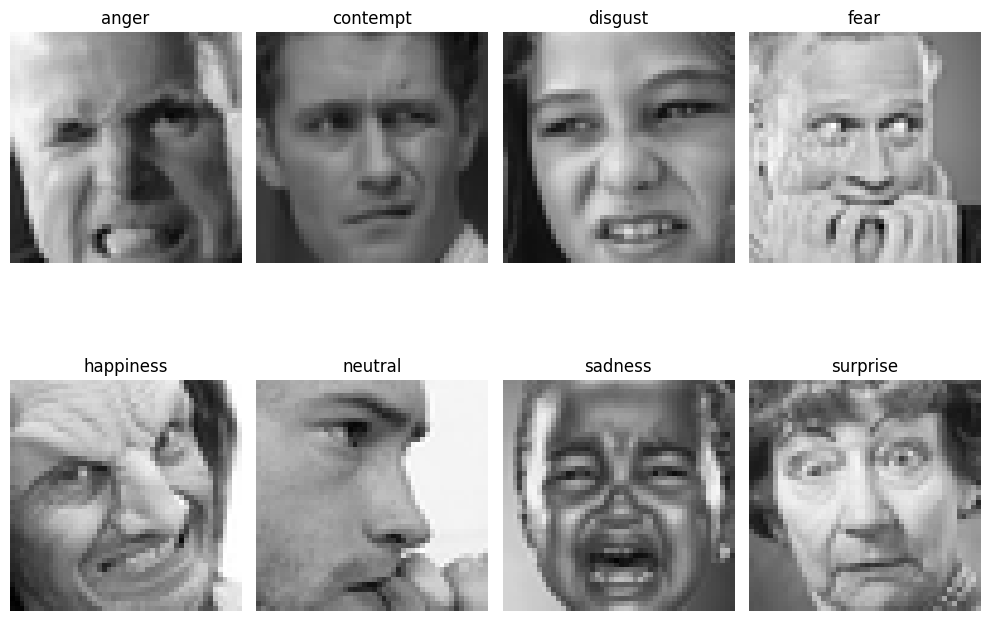

In [ ]:
data_dir = '/content/FER2013+/train'

classes = sorted(os.listdir(data_dir))

examples = {}

for cls in classes:
    cls_path = os.path.join(data_dir, cls)
    if os.path.isdir(cls_path):
        img_name = os.listdir(cls_path)[0]
        img_path = os.path.join(cls_path, img_name)
        examples[cls] = Image.open(img_path)

plt.figure(figsize=(10, 8))
for i, (cls, img) in enumerate(examples.items()):
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Обучение

Функция для обучения

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs, patience=3):
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", unit="batch"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}!")
            break

        scheduler.step(val_loss)

        current_lr = optimizer.param_groups[0]['lr']
        print(f"Current Learning Rate: {current_lr}")

    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")



Загрузка предобученной модели

In [ ]:
model = models.resnet50(pretrained = False)
model.fc = nn.Linear(model.fc.in_features, 8)
model.load_state_dict(torch.load('resnet50-FER2013+', map_location=torch.device('cpu'), weights_only=True))

<All keys matched successfully>

In [ ]:
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(model.fc.in_features, 8)
)

In [ ]:
for param in model.parameters():
  param.requires_grad = False

for param in model.fc.parameters():
  param.requires_grad = True

In [ ]:
for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

conv1.weight: requires_grad=False
bn1.weight: requires_grad=False
bn1.bias: requires_grad=False
layer1.0.conv1.weight: requires_grad=False
layer1.0.bn1.weight: requires_grad=False
layer1.0.bn1.bias: requires_grad=False
layer1.0.conv2.weight: requires_grad=False
layer1.0.bn2.weight: requires_grad=False
layer1.0.bn2.bias: requires_grad=False
layer1.0.conv3.weight: requires_grad=False
layer1.0.bn3.weight: requires_grad=False
layer1.0.bn3.bias: requires_grad=False
layer1.0.downsample.0.weight: requires_grad=False
layer1.0.downsample.1.weight: requires_grad=False
layer1.0.downsample.1.bias: requires_grad=False
layer1.1.conv1.weight: requires_grad=False
layer1.1.bn1.weight: requires_grad=False
layer1.1.bn1.bias: requires_grad=False
layer1.1.conv2.weight: requires_grad=False
layer1.1.bn2.weight: requires_grad=False
layer1.1.bn2.bias: requires_grad=False
layer1.1.conv3.weight: requires_grad=False
layer1.1.bn3.weight: requires_grad=False
layer1.1.bn3.bias: requires_grad=False
layer1.2.conv1.wei

In [ ]:
num_epochs = 10
learning_rate = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/10 - Validation: 100%|██████████| 45/45 [00:16<00:00,  2.70batch/s]


Epoch 1/10, Validation Loss: 0.2337, Accuracy: 91.86%
Current Learning Rate: 0.0001


Epoch 2/10 - Validation: 100%|██████████| 45/45 [00:16<00:00,  2.81batch/s]


Epoch 2/10, Validation Loss: 0.2069, Accuracy: 92.92%
Current Learning Rate: 0.0001


Epoch 3/10 - Validation: 100%|██████████| 45/45 [00:16<00:00,  2.74batch/s]


Epoch 3/10, Validation Loss: 0.1909, Accuracy: 93.52%
Current Learning Rate: 0.0001


Epoch 4/10 - Validation: 100%|██████████| 45/45 [00:15<00:00,  2.89batch/s]


Epoch 4/10, Validation Loss: 0.2023, Accuracy: 92.78%
Current Learning Rate: 0.0001


Epoch 5/10 - Validation: 100%|██████████| 45/45 [00:15<00:00,  2.86batch/s]


Epoch 5/10, Validation Loss: 0.1903, Accuracy: 92.92%
Current Learning Rate: 0.0001


Epoch 6/10 - Validation: 100%|██████████| 45/45 [00:15<00:00,  2.89batch/s]


Epoch 6/10, Validation Loss: 0.1886, Accuracy: 93.06%
Current Learning Rate: 0.0001


Epoch 7/10 - Validation: 100%|██████████| 45/45 [00:15<00:00,  2.91batch/s]


Epoch 7/10, Validation Loss: 0.1874, Accuracy: 93.38%
Current Learning Rate: 0.0001


Epoch 8/10 - Validation: 100%|██████████| 45/45 [00:15<00:00,  2.92batch/s]


Epoch 8/10, Validation Loss: 0.1959, Accuracy: 93.13%
Current Learning Rate: 0.0001


Epoch 9/10 - Validation: 100%|██████████| 45/45 [00:15<00:00,  2.87batch/s]


Epoch 9/10, Validation Loss: 0.1931, Accuracy: 93.38%
Current Learning Rate: 0.0001


Epoch 10/10 - Validation: 100%|██████████| 45/45 [00:15<00:00,  2.90batch/s]


Epoch 10/10, Validation Loss: 0.1942, Accuracy: 93.13%
Early stopping triggered at epoch 10!


Testing: 100%|██████████| 111/111 [00:34<00:00,  3.17batch/s]

Test Loss: 0.4881, Test Accuracy: 84.55%


In [ ]:
torch.save(model, 'resnet50_FER2013+_full_model')

## Тест

In [ ]:
model = torch.load('resnet50_FER2013+_full_model')
model.eval()

<ipython-input-13-ec0d9db54907>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('resnet50_FER2013+_full_model')


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

100%|██████████| 111/111 [00:36<00:00,  3.01it/s]


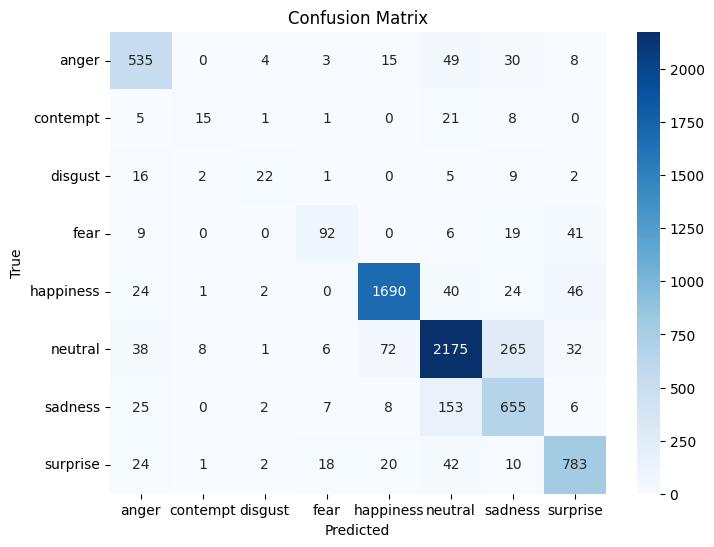

In [ ]:
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
emotions = ['Neutral', 'Happy', 'Sad', 'Surprise', 'Fear', 'Disgust', 'Angry','Contempt']

In [ ]:
def preprocess_image(face):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((112, 112)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(face).unsqueeze(0)

In [ ]:
def predict_emotion(image_path, model):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    detector = MTCNN()
    faces = detector.detect_faces(image_rgb)

    if not faces:
        return "Лицо не обнаружено!"

    x, y, w, h = faces[0]['box']
    face = image_rgb[y:y + h, x:x + w]

    face_tensor = preprocess_image(face)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    face_tensor = face_tensor.to(device)

    model.eval()
    with torch.no_grad():
        outputs, _, _ = model(face_tensor)
        _, predicted_index = torch.max(outputs, 1)

    emotion = emotions[predicted_index.item()]

    fig, ax = plt.subplots()
    ax.imshow(image_rgb)
    rect = plt.Rectangle((x, y), w, h, edgecolor='red', linewidth=2, facecolor='none')
    ax.add_patch(rect)
    plt.text(x, y - 10, emotion, fontsize=14, color='red', bbox=dict(facecolor='white', alpha=0.8))
    plt.axis('off')
    plt.show()

    return emotion